<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Dz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем необходимые библиотеки и считаем датасет

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('flights.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492725 entries, 0 to 3492724
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    float64
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             float64
 24

Посмотрим у каких авиакомпаний больше всего задержек более чем на 15 минут. Также посмотрим на количество полётов у этих авиакомпаний, чтобы предположить, может ли влиять их загруженность на количество задержек.

<ipython-input-105-374e9cc1889c>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_10_delayed_airlines['AIRLINE'])


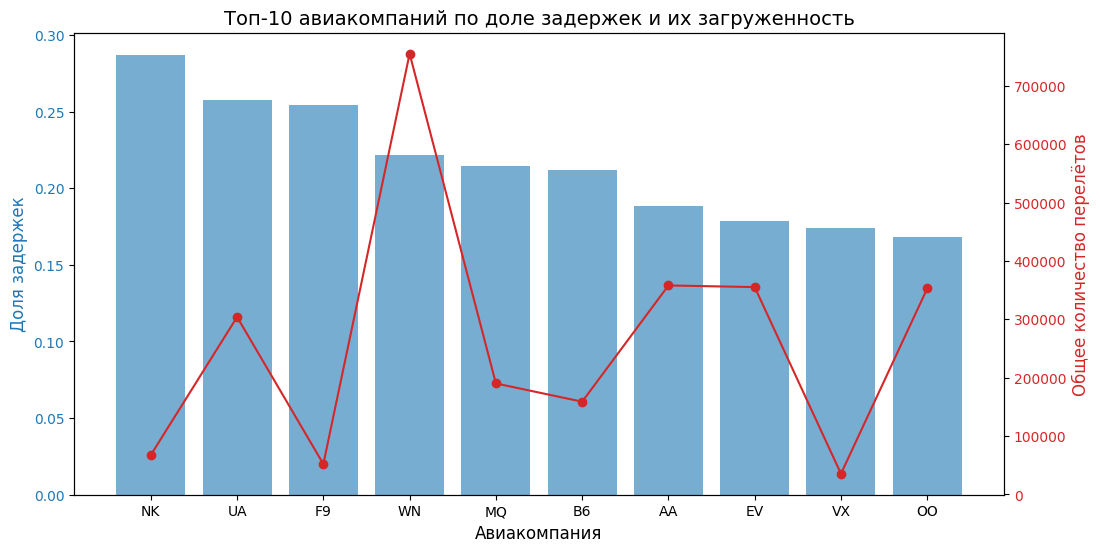

In [105]:

total_flights_airline = df['AIRLINE'].value_counts()
delayed_flights_airline = df[df['DEPARTURE_DELAY'] > 15]['AIRLINE'].value_counts()
delay_ratio_airline = (delayed_flights_airline / total_flights_airline).sort_values(ascending=False)
# Преобразуем результат в DataFrame для удобства
delay_ratio_airline_df = delay_ratio_airline.reset_index()
delay_ratio_airline_df.columns = ['AIRLINE', 'DELAY_RATIO']

# Добавляем столбец с общим количеством перелётов для этих авиакомпаний
delay_ratio_airline_df = delay_ratio_airline_df.merge(
    total_flights_airline.rename('TOTAL_FLIGHTS'),
    left_on='AIRLINE',
    right_index=True
)

# Выбираем топ-10 авиакомпаний по доле задержек
top_10_delayed_airlines = delay_ratio_airline_df.head(10)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Первая ось (левая): доля задержек
color = 'tab:blue'
ax1.set_xlabel('Авиакомпания', fontsize=12)
ax1.set_ylabel('Доля задержек', fontsize=12, color=color)
ax1.bar(top_10_delayed_airlines['AIRLINE'], top_10_delayed_airlines['DELAY_RATIO'], color=color, alpha=0.6, label='Доля задержек')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_10_delayed_airlines['AIRLINE'])

# Вторая ось (правая): общее количество перелётов
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Общее количество перелётов', fontsize=12, color=color)
ax2.plot(top_10_delayed_airlines['AIRLINE'], top_10_delayed_airlines['TOTAL_FLIGHTS'], color=color, marker='o', label='Общее количество перелётов')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Топ-10 авиакомпаний по доле задержек и их загруженность', fontsize=14)
plt.show()


Проблема 1: У трёх авиакомпаний каждый четвёртый полёт происходит с задержкой более чем 15 минут. У некоторых авиакомпаний (например, NK и F9), несмотря на не очень большое количество перелётов высокий процент задержек.

Теперь посмотрим на аэропорты с большим количеством задержек. Также посмотрим на количество вылетов из этих аэропортов, чтобы предположить, может ли влиять их загруженность на количество задержек.

   ORIGIN_AIRPORT  DELAY_RATIO
0             ILG     0.370000
1             GST     0.350000
2             MVY     0.341270
3             GUM     0.317972
4             STC     0.301205
5             OTH     0.290909
6             ADK     0.290323
7             PBG     0.287234
8             UST     0.268041
9             HYA     0.265306
10            ACK     0.262626
11            CEC     0.257895
12            ORD     0.254164
13            MDW     0.253297
14            BWI     0.250860
15            HOU     0.242024
16            DAL     0.241602
17            BPT     0.238318
18            EWR     0.236638
19            DEN     0.236327


<ipython-input-103-3ee9ceb7d14b>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_10_delayed_airports['ORIGIN_AIRPORT'])


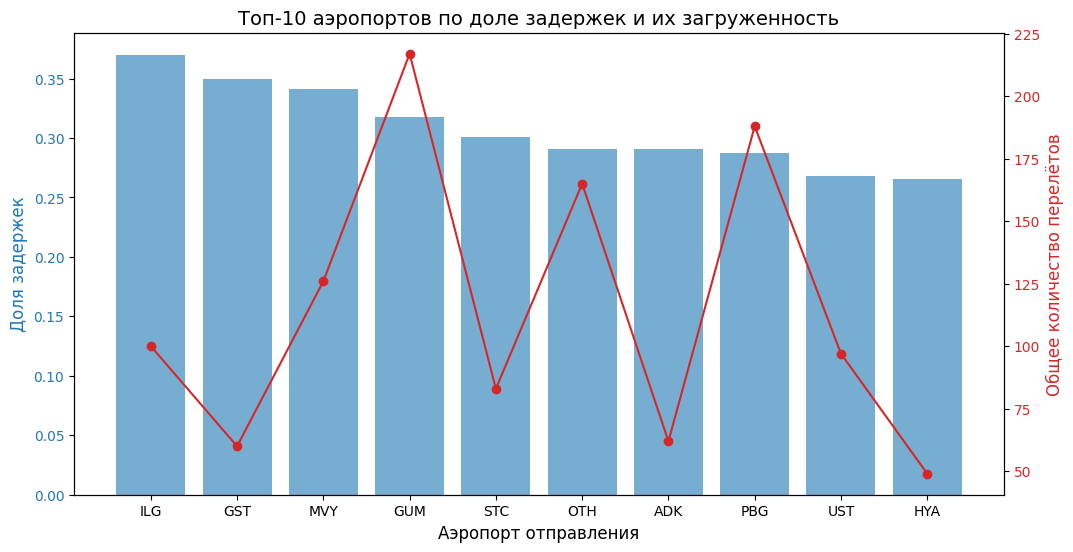

In [103]:

total_flights = df['ORIGIN_AIRPORT'].value_counts()
delayed_flights = df[df['DEPARTURE_DELAY'] > 15]['ORIGIN_AIRPORT'].value_counts()
delay_ratio = (delayed_flights / total_flights).sort_values(ascending=False)
delay_ratio_df = delay_ratio.reset_index()
delay_ratio_df.columns = ['ORIGIN_AIRPORT', 'DELAY_RATIO']
print(delay_ratio_df.head(20))

top_10_delayed_airports = delay_ratio_df.head(10)
# Добавляем столбец с общим количеством перелётов для этих аэропортов
top_10_delayed_airports = top_10_delayed_airports.merge(
    total_flights.rename('TOTAL_FLIGHTS'),
    left_on='ORIGIN_AIRPORT',
    right_index=True
)

# Строим диаграмму
fig, ax1 = plt.subplots(figsize=(12, 6))

# Первая ось (левая): доля задержек
color = 'tab:blue'
ax1.set_xlabel('Аэропорт отправления', fontsize=12)
ax1.set_ylabel('Доля задержек', fontsize=12, color=color)
ax1.bar(top_10_delayed_airports['ORIGIN_AIRPORT'], top_10_delayed_airports['DELAY_RATIO'], color=color, alpha=0.6, label='Доля задержек')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_10_delayed_airports['ORIGIN_AIRPORT'])

# Вторая ось (правая): общее количество перелётов
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Общее количество перелётов', fontsize=12, color=color)
ax2.plot(top_10_delayed_airports['ORIGIN_AIRPORT'], top_10_delayed_airports['TOTAL_FLIGHTS'], color=color, marker='o', label='Общее количество перелётов')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Топ-10 аэропортов по доле задержек и их загруженность', fontsize=14)
plt.show()


Проблема 2: У топ-15 по количеству задержек аэропортов каждый 4 вылет происходит с задержкой больше 15 минут.

Проверим зависимость между количеством задержек и количеством полётов по хвостовому номеру

   TAIL_NUMBER  DELAY_RATIO  TOTAL_FLIGHTS
0       N61881     0.475962            208
1       N351AA     0.388430            121
2       N12225     0.387387            555
3       N697SW     0.380884            701
4       N41140     0.378995            219
5       N356AA     0.370629            143
6       N38268     0.368015            519
7       N78285     0.365385            624
8       N14242     0.364791            551
9       N14230     0.364421            579
10      N14228     0.360934            471
11      N37273     0.359240            579
12      N33266     0.359023            532
13      N202FR     0.357337            736
14      N368AA     0.355769            104
15      N7818L     0.355731            253
16      N271AY     0.355372            121
17      N76288     0.354430            553
18      N73259     0.354317            556
19      N37287     0.354098            610


<ipython-input-115-4e9aa1263efa>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_10_delay_ratio_df['TAIL_NUMBER'])


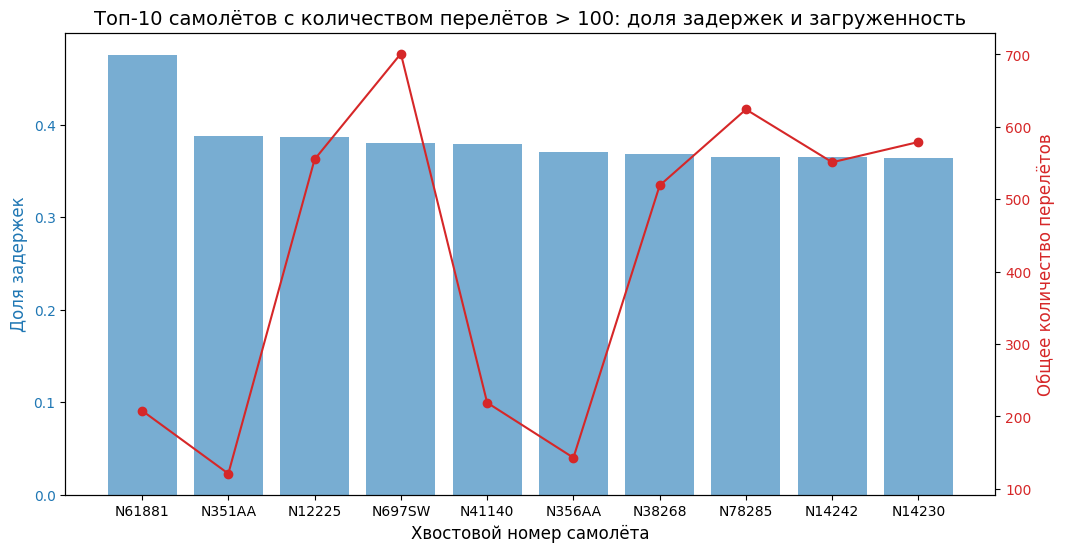

In [115]:

total_flights = df['TAIL_NUMBER'].value_counts()
more_than_100_flights = total_flights[total_flights > 100].index
filtered_df = df[df['TAIL_NUMBER'].isin(more_than_100_flights)]
delayed_flights = filtered_df[filtered_df['DEPARTURE_DELAY'] > 15]['TAIL_NUMBER'].value_counts()
delay_ratio = (delayed_flights / total_flights[more_than_100_flights]).sort_values(ascending=False)
delay_ratio_df = delay_ratio.reset_index()
delay_ratio_df.columns = ['TAIL_NUMBER', 'DELAY_RATIO']
delay_ratio_df = delay_ratio_df.merge(
    total_flights.rename('TOTAL_FLIGHTS'),
    left_on='TAIL_NUMBER',
    right_index=True
)
print(delay_ratio_df.head(20))

# Построим диаграмму
top_10_delay_ratio_df = delay_ratio_df.head(10)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Первая ось (левая): доля задержек
color = 'tab:blue'
ax1.set_xlabel('Хвостовой номер самолёта', fontsize=12)
ax1.set_ylabel('Доля задержек', fontsize=12, color=color)
ax1.bar(top_10_delay_ratio_df['TAIL_NUMBER'], top_10_delay_ratio_df['DELAY_RATIO'], color=color, alpha=0.6, label='Доля задержек')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_10_delay_ratio_df['TAIL_NUMBER'])

# Вторая ось (правая): общее количество перелётов
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Общее количество перелётов', fontsize=12, color=color)
ax2.plot(top_10_delay_ratio_df['TAIL_NUMBER'], top_10_delay_ratio_df['TOTAL_FLIGHTS'], color=color, marker='o', label='Общее количество перелётов')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Топ-10 самолётов с количеством перелётов > 100: доля задержек и загруженность', fontsize=14)
plt.show()

Проблема 3: У некоторых самолётов высокий уровень задержек (у N61881 этот показатель достигает почти 50%)

Проверим зависимость между количеством вылетов и количеством задержек

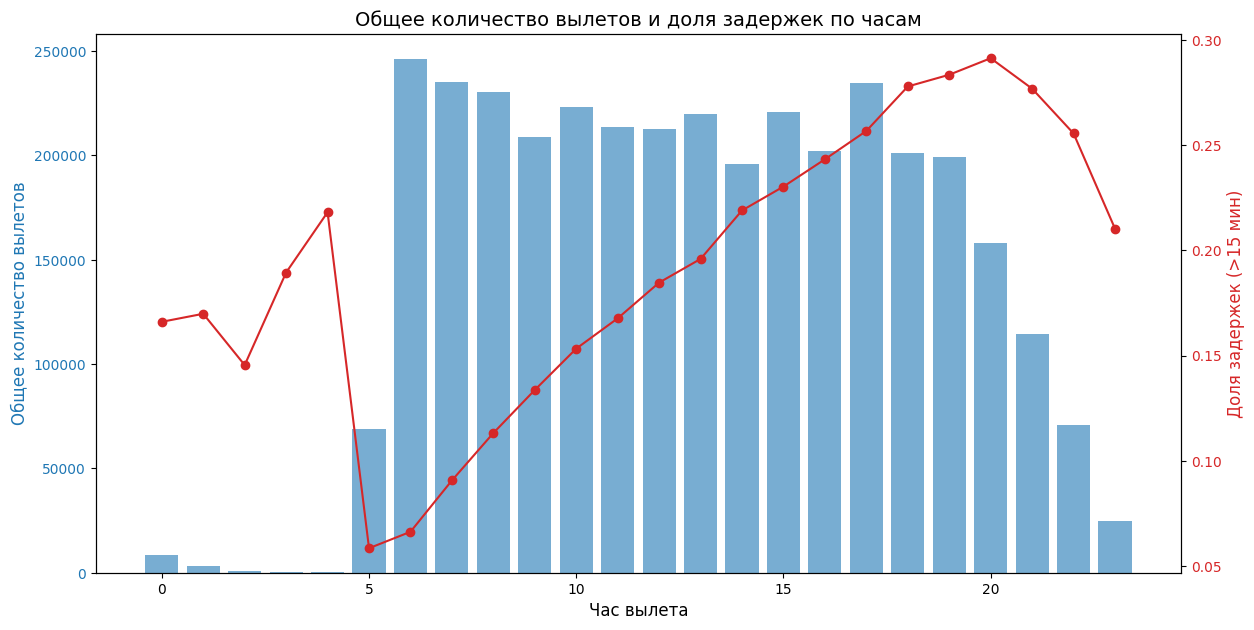

In [122]:

df['DEPARTURE_HOUR'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'], format='%H%M', errors='coerce').dt.hour
flights_by_hour = df.groupby('DEPARTURE_HOUR').size()
delays_by_hour = df[df['DEPARTURE_DELAY'] > 15].groupby('DEPARTURE_HOUR').size()
delay_ratio_by_hour = (delays_by_hour / flights_by_hour).fillna(0)

hourly_data = pd.DataFrame({
    'TOTAL_FLIGHTS': flights_by_hour,
    'DELAY_RATIO': delay_ratio_by_hour
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Час вылета', fontsize=12)
ax1.set_ylabel('Общее количество вылетов', fontsize=12, color=color)
ax1.bar(hourly_data['DEPARTURE_HOUR'], hourly_data['TOTAL_FLIGHTS'], color=color, alpha=0.6, label='Общее количество вылетов')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Доля задержек (>15 мин)', fontsize=12, color=color)
ax2.plot(hourly_data['DEPARTURE_HOUR'], hourly_data['DELAY_RATIO'], color=color, marker='o', label='Доля задержек')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Общее количество вылетов и доля задержек по часам', fontsize=14)
plt.show()

Проблема 4: с 17 до 22 часов каждый четвёртый вылет задерживается более чем на 15 минут

Посмотрим у каких авиакомпаний самое большое количество отмен рейсов

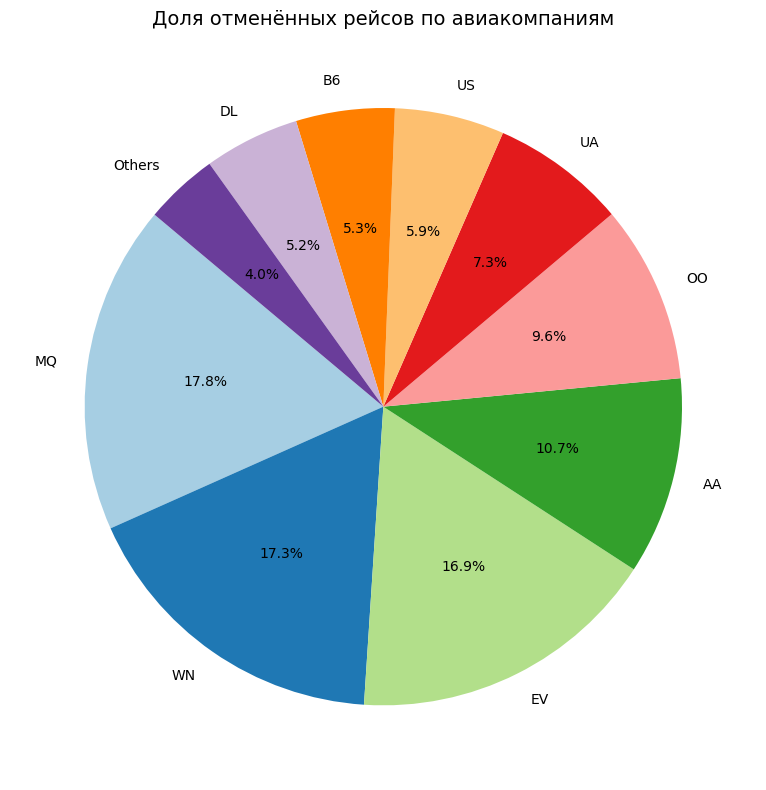

In [125]:

cancelled_flights = df[df['CANCELLED'] == 1]
cancelled_by_airline = cancelled_flights['AIRLINE'].value_counts()
total_cancelled = cancelled_by_airline.sum()
cancelled_by_airline_ratio = (cancelled_by_airline / total_cancelled) * 100

# Определяем порог для объединения
threshold = 5
others = cancelled_by_airline_ratio[cancelled_by_airline_ratio < threshold].sum()
filtered_data = cancelled_by_airline_ratio[cancelled_by_airline_ratio >= threshold]

filtered_data['Others'] = others
plt.figure(figsize=(10, 8))
plt.pie(filtered_data, labels=filtered_data.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Доля отменённых рейсов по авиакомпаниям', fontsize=14)
plt.tight_layout()
plt.show()

Проблема 5: Первые три авиакомпании по количеству отменённых рейсов имеют больше половины отменённых рейсов от общего числа. При этом только авиакомпания 'WN' может оправдать себя большим общим количеством полётов.